In [2]:
from tvb.simulator.lab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plc
import time as tm
import mest_function
from utils import *
import logging
logging.disable(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Data
data_path = '/Users/gpret/Desktop/MEDICINA/TVB_Distribution/demo_scripts/myScripts/For_OHBM/For_OHBM/tutorial_data'

In [4]:
con = connectivity.Connectivity.from_file(f'{data_path}/connectivity.vep.zip')
con.tract_lengths = np.zeros((con.tract_lengths.shape))             # no time-delays
con.weights[np.diag_indices(con.weights.shape[0])] = 0 #mette a zero i weights degli indici diagonali, che sono quelli di una
#area con se stessa
# con.weights = np.log(con.weights+1)
con.weights /= con.weights.max() # a /= b equivale a fare a = a/b
con.configure()
nb_regions = con.number_of_regions
roi = con.region_labels

In [5]:
# Coupling
coupl = coupling.Difference(a=np.array([-0.2]))

# Integrators
hiss = noise.Additive(nsig = np.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunDeterministic(dt=0.05) 

# Monitors
mons = [monitors.TemporalAverage(period=3)]

In [6]:
EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

## ATTENZIONE 
Le timeseries nelle analisi di spettro sono da dividere per 3.
Con dt troppo grandi (0.1) e x0 troppo bassi (<-2.4) non funziona. Mettere dt a 0.05

## Stimulus setup
Finché non risolvo la cosa dell'integratore, non mi serve

1.55

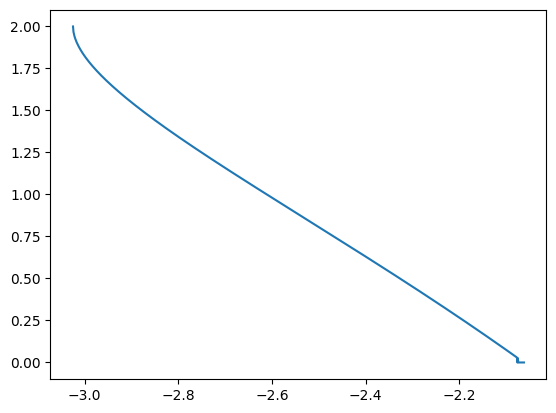

In [7]:
all_the_deltas, X0s = mest_function.f1_find_the_delta()
round(all_the_deltas[np.where(X0s == round(-2.9, 3))[0][0]], 2)

In [14]:
X0 = np.arange(-2.8,-2.7,0.1)
for j, jj in enumerate(X0):
    X0[j] = round(jj,1)
X0 = X0[::-1]

In [15]:
from scipy.optimize import fsolve
def s1_inters_bif_line(s1p, s1x0): #intersection of the bifurcation with dz = 0
        s1z, s1x1 = s1p
        return (s1x1**3 + 2*s1x1**2 - 4.1 + s1z, s1x1 - s1x0 - s1z/4)
startingx1 = []
startingz = []
for m in X0:
    f1z, f1x1 = fsolve(s1_inters_bif_line, (3, -1), m)
    startingz.append(f1z)
    startingx1.append(f1x1)

In [16]:
import pandas as pd
data = {'x0': X0, 'x1': startingx1, 'z': startingz}
startings = pd.DataFrame(data)
#startings.loc[0]['x1'] = startings.loc[1]['x1']
#startings.loc[0]['z'] = startings.loc[1]['z']
startings

x0        x1        z
0 -2.8 -1.880583  3.67767

In [21]:
Is = np.arange(1.65, 1.85, 0.1)
for j, jj in enumerate(Is):
    Is[j] = round(jj,2)
    
pastduration = [200]*len(Is)

A = np.ones((len(Is),len(np.arange(200,2200,200))))
df = pd.DataFrame(A, index = Is, columns = np.arange(200,2200,200))

In [22]:
df

200   400   600   800   1000  1200  1400  1600  1800  2000
1.65   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0
1.75   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0
1.85   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0

In [13]:
for x0 in X0: 
    print('\n Vado con ', x0, '\n')
    
    for i, ii in enumerate(Is): 
        seizing = False
        duration = pastduration[i]
        
        while(seizing==False): 
            
            dt = 0.05
            onset = 500 # ms
            stim_length = onset + duration # stimulation length (including onset) ms
            simulation_length = 3000 # ms
            freq = 1 #50/1000 # frequency converted to 1/ms
            T = 1/freq # pulse repetition period [ms]
            tau = 1 # pulse width [ms]
            I = ii # intensity [mA]

            # Temporal stimulation pattern
            class vector1D(equations.DiscreteEquation):
                equation = equations.Final(default="emp")
            eqn_t = vector1D()
            parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
            pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
            pulse1_ts = [p[1] for p in pulse1]
            parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
            pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
            pulse2_ts = [p[1] for p in pulse2]
            pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
            stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
            eqn_t.parameters['emp'] = np.copy(stimulus_ts)
            print("Stimuli applied of I:", ii, 'and duration:', duration)
            
            # Here we set up the EZ node such that it is close to the critical working point, i.e. the seizure threshold
            x0ez= x0
            x0pz= -2.4
            x0num=-2.4

            epileptors = models.Epileptor(r=np.array([0.00035]))
            epileptors.x0 = x0num*np.ones(nb_regions)
            epileptors.x0[idx_EZ] = x0ez
            for id in idx_PZ:
                epileptors.x0[id] = x0pz
                x0pz -= 0.01

            # Initial conditions
            initx1 = round(float(startings.loc[startings['x0'] == x0]['x1']), 4)
            initz = round(float(startings.loc[startings['x0'] == x0]['z']), 4)
            init_cond = np.array([initx1, -1.87492138e+01, initz, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
            print('Initial conditions ',init_cond)
            init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

            # Spatial stimulation pattern (via weights accross the network nodes)
            stim_weight = 3
            stim_weights = np.zeros((nb_regions))
            stim_weights[idx_EZ] = np.array([stim_weight])
            stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                              connectivity=con,
                                              weight=stim_weights)
            stimulus.configure_space()
            stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

            # Simulator
            sim = simulator.Simulator(model=epileptors, 
                                      stimulus=stimulus, 
                                      initial_conditions=init_cond_reshaped, 
                                      connectivity=con, 
                                      coupling=coupl, 
                                      integrator=heunint, 
                                      monitors=mons)

            sim.configure()

            # Run
            print("Starting simulation...")
            tic = tm.time()
            ttavg = sim.run(simulation_length=simulation_length)
            print("Finished simulation.")
            print('execute for ' + str(tm.time()-tic))
            
            tts = ttavg[0][0]
            tavg = ttavg[0][1]
            srcSig = tavg[:,0,:,0]
            start_idx = 0
            end_idx = tavg.shape[0]
            
            srcSig_normal=srcSig/np.ptp(srcSig)
            mySig = srcSig_normal[int((stim_length+100)/3):int((stim_length+400)/3), np.where(roi==EZ)[0][0]]
            variance = np.mean((mySig - np.mean(mySig))**2)
            if variance > 0.009:
                print('Ha iniziato a I: ', ii, 'e durata: ', duration)
                pastduration[i] = duration
                seizing = True
            else:
                df.loc[ii][duration] = 0.
                duration = duration + 200
                
            if duration > 2000:
                seizing = True
    
    df.to_csv(f'{x0}completo.csv')

Vado con  -2.8
Stimuli applied of I: 0.55 and duration: 1000
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 105.96472454071045
Stimuli applied of I: 0.55 and duration: 1200
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 102.53536868095398
Stimuli applied of I: 0.55 and duration: 1400
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 103.72569346427917
Stimuli applied of I: 0.55 and duration: 1600
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 101.00091814994812
Stimuli applied of I: 0.5

Finished simulation.
execute for 107.9350802898407
Stimuli applied of I: 1.15 and duration: 1200
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 101.82686614990234
Stimuli applied of I: 1.15 and duration: 1400
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 100.31211280822754
Ha iniziato a I:  1.15 e durata:  1400
Stimuli applied of I: 1.25 and duration: 1000
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 96.48186016082764
Stimuli applied of I: 1.25 and duration: 1200
Initial conditions  [-1.88060000e+00 -1.87492138e+01  3.67770000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Fin

Finished simulation.
execute for 79.91377544403076
Stimuli applied of I: 0.95 and duration: 1800
Initial conditions  [-1.93550000e+00 -1.87492138e+01  3.85820000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 87.55011320114136
Stimuli applied of I: 0.95 and duration: 2000
Initial conditions  [-1.93550000e+00 -1.87492138e+01  3.85820000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 84.1818904876709
Stimuli applied of I: 1.05 and duration: 1600
Initial conditions  [-1.93550000e+00 -1.87492138e+01  3.85820000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 80.17336893081665
Stimuli applied of I: 1.05 and duration: 1800
Initial conditions  [-1.93550000e+00 -1.87492138e+01  3.85820000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 90.683386564

Finished simulation.
execute for 63.299498558044434
Stimuli applied of I: 0.55 and duration: 1200
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.41646766662598
Stimuli applied of I: 0.55 and duration: 1400
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.6473822593689
Stimuli applied of I: 0.55 and duration: 1600
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.66948914527893
Stimuli applied of I: 0.55 and duration: 1800
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.59974002

Finished simulation.
execute for 62.64700150489807
Stimuli applied of I: 1.65 and duration: 1800
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.84191966056824
Stimuli applied of I: 1.65 and duration: 2000
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.48511242866516
Ha iniziato a I:  1.65 e durata:  2000
Stimuli applied of I: 1.75 and duration: 1400
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 62.085521936416626
Stimuli applied of I: 1.75 and duration: 1600
Initial conditions  [-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Fini

## Analysis

In [34]:
csvfile = f'{X0[0]}.csv'
dfan = pd.read_csv(csvfile, index_col=0)
dfan

200  400  600  800  1000  1200  1400  1600  1800  2000
0.05  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.15  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.25  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.35  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.45  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.55  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.65  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.75  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0
0.85  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   1.0
0.95  0.0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   1.0   1.0
1.05  0.0  0.0  0.0  0.0   0.0   0.0   0.0   1.0   1.0   1.0
1.15  0.0  0.0  0.0  0.0   0.0   0.0   1.0   1.0   1.0   1.0
1.25  0.0  0.0  0.0  0.0   0.0   0.0   1.0   1.0   1.0   1.0
1.35  0.0  0.0  0.0  0.0   0.0   1.0   1.0   1.0   1.0   1.0
1.45  0.0  0.0  0.0  0.0   0.0   1.0   1.0   1.0   1.0   1.0
1.55  0.0  0.0  0.0  0.0   0.0   1.0   1.0   1.0   1.0   1.0
1.65  1.0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0
1.75  1.0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0
1.85  1.0  1.0  1.0  1.0   1.0   1.0   1.0   1.0   1.0   1.0

In [39]:
csvfile = f'{X0[0]}.csv'
dfan = pd.read_csv(csvfile, index_col=0)
coordinates = []
for c in dfan.index:
    for cc in dfan.columns:
        if dfan.loc[c][cc] == 1.0:
            coordinates.append([c, int(cc), X0[0]])
coordinates

[[0.85, 2000, -2.8],
 [0.95, 1800, -2.8],
 [0.95, 2000, -2.8],
 [1.05, 1600, -2.8],
 [1.05, 1800, -2.8],
 [1.05, 2000, -2.8],
 [1.15, 1400, -2.8],
 [1.15, 1600, -2.8],
 [1.15, 1800, -2.8],
 [1.15, 2000, -2.8],
 [1.25, 1400, -2.8],
 [1.25, 1600, -2.8],
 [1.25, 1800, -2.8],
 [1.25, 2000, -2.8],
 [1.35, 1200, -2.8],
 [1.35, 1400, -2.8],
 [1.35, 1600, -2.8],
 [1.35, 1800, -2.8],
 [1.35, 2000, -2.8],
 [1.45, 1200, -2.8],
 [1.45, 1400, -2.8],
 [1.45, 1600, -2.8],
 [1.45, 1800, -2.8],
 [1.45, 2000, -2.8],
 [1.55, 1200, -2.8],
 [1.55, 1400, -2.8],
 [1.55, 1600, -2.8],
 [1.55, 1800, -2.8],
 [1.55, 2000, -2.8],
 [1.65, 200, -2.8],
 [1.65, 400, -2.8],
 [1.65, 600, -2.8],
 [1.65, 800, -2.8],
 [1.65, 1000, -2.8],
 [1.65, 1200, -2.8],
 [1.65, 1400, -2.8],
 [1.65, 1600, -2.8],
 [1.65, 1800, -2.8],
 [1.65, 2000, -2.8],
 [1.75, 200, -2.8],
 [1.75, 400, -2.8],
 [1.75, 600, -2.8],
 [1.75, 800, -2.8],
 [1.75, 1000, -2.8],
 [1.75, 1200, -2.8],
 [1.75, 1400, -2.8],
 [1.75, 1600, -2.8],
 [1.75, 1800, -2.8],


## Full original script to do some checkings

Stimuli applied from the SEEG electrode


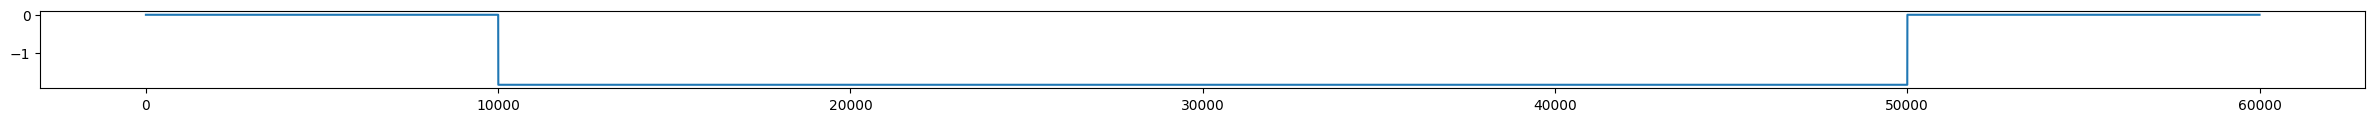

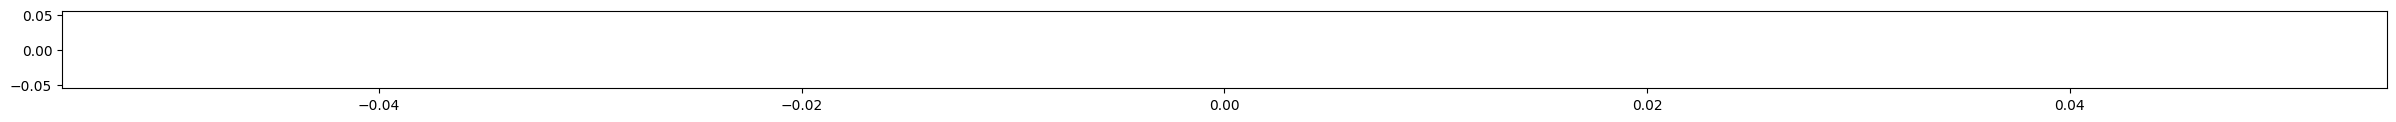

In [427]:
dt = 0.05
onset = 500 # ms
stim_length = onset + 2000 # stimulation length (including onset) ms
simulation_length = 3000 # ms
freq = 1#50/1000 # frequency converted to 1/ms
T = 1/freq # pulse repetition period [ms]
tau = 1 # pulse width [ms]
I = 1.85 # intensity [mA]

# Temporal stimulation pattern
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]
pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

print("Stimuli applied from the SEEG electrode")
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts[60000:70000])
plt.show()

In [428]:
# Here we set up the EZ node such that it is close to the critical working point, i.e. the seizure threshold
x0ez=-3.
x0pz=-2.1
x0num=-2.4

#Here I set the x0 emulating a temporal sclerosis, which is worse in in the anterior right hippocampus but also made 
#damage to nearby areas, as showed in common MRI findings (https://radiopaedia.org/articles/1664)

EZ = ['Right-Hippocampus-anterior']
PZ = ['Right-Hippocampus-posterior', 'Right-Parahippocampal-cortex', 'Right-Rhinal-cortex', 'Right-Amygdala', 'Right-T3-anterior', 
      'Right-Posterior-cingulate-cortex-dorsal', 'Right-Posterior-cingulate-cortex-retrosplenial-gyrus']
idx_EZ = np.where(roi == EZ)
idx_PZ = [np.where(roi == pz) for pz in PZ]

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.01

# Initial conditions
init_cond = np.array([initx1 , -1.87492138e+01, initz, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

# Spatial stimulation pattern (via weights accross the network nodes)
stim_weight = 3
stim_weights = np.zeros((nb_regions))
stim_weights[idx_EZ] = np.array([stim_weight])
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=con,
                                  weight=stim_weights)
stimulus.configure_space()
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus, 
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98740000e+00 -1.87492138e+01  4.05030000e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 107.06729817390442


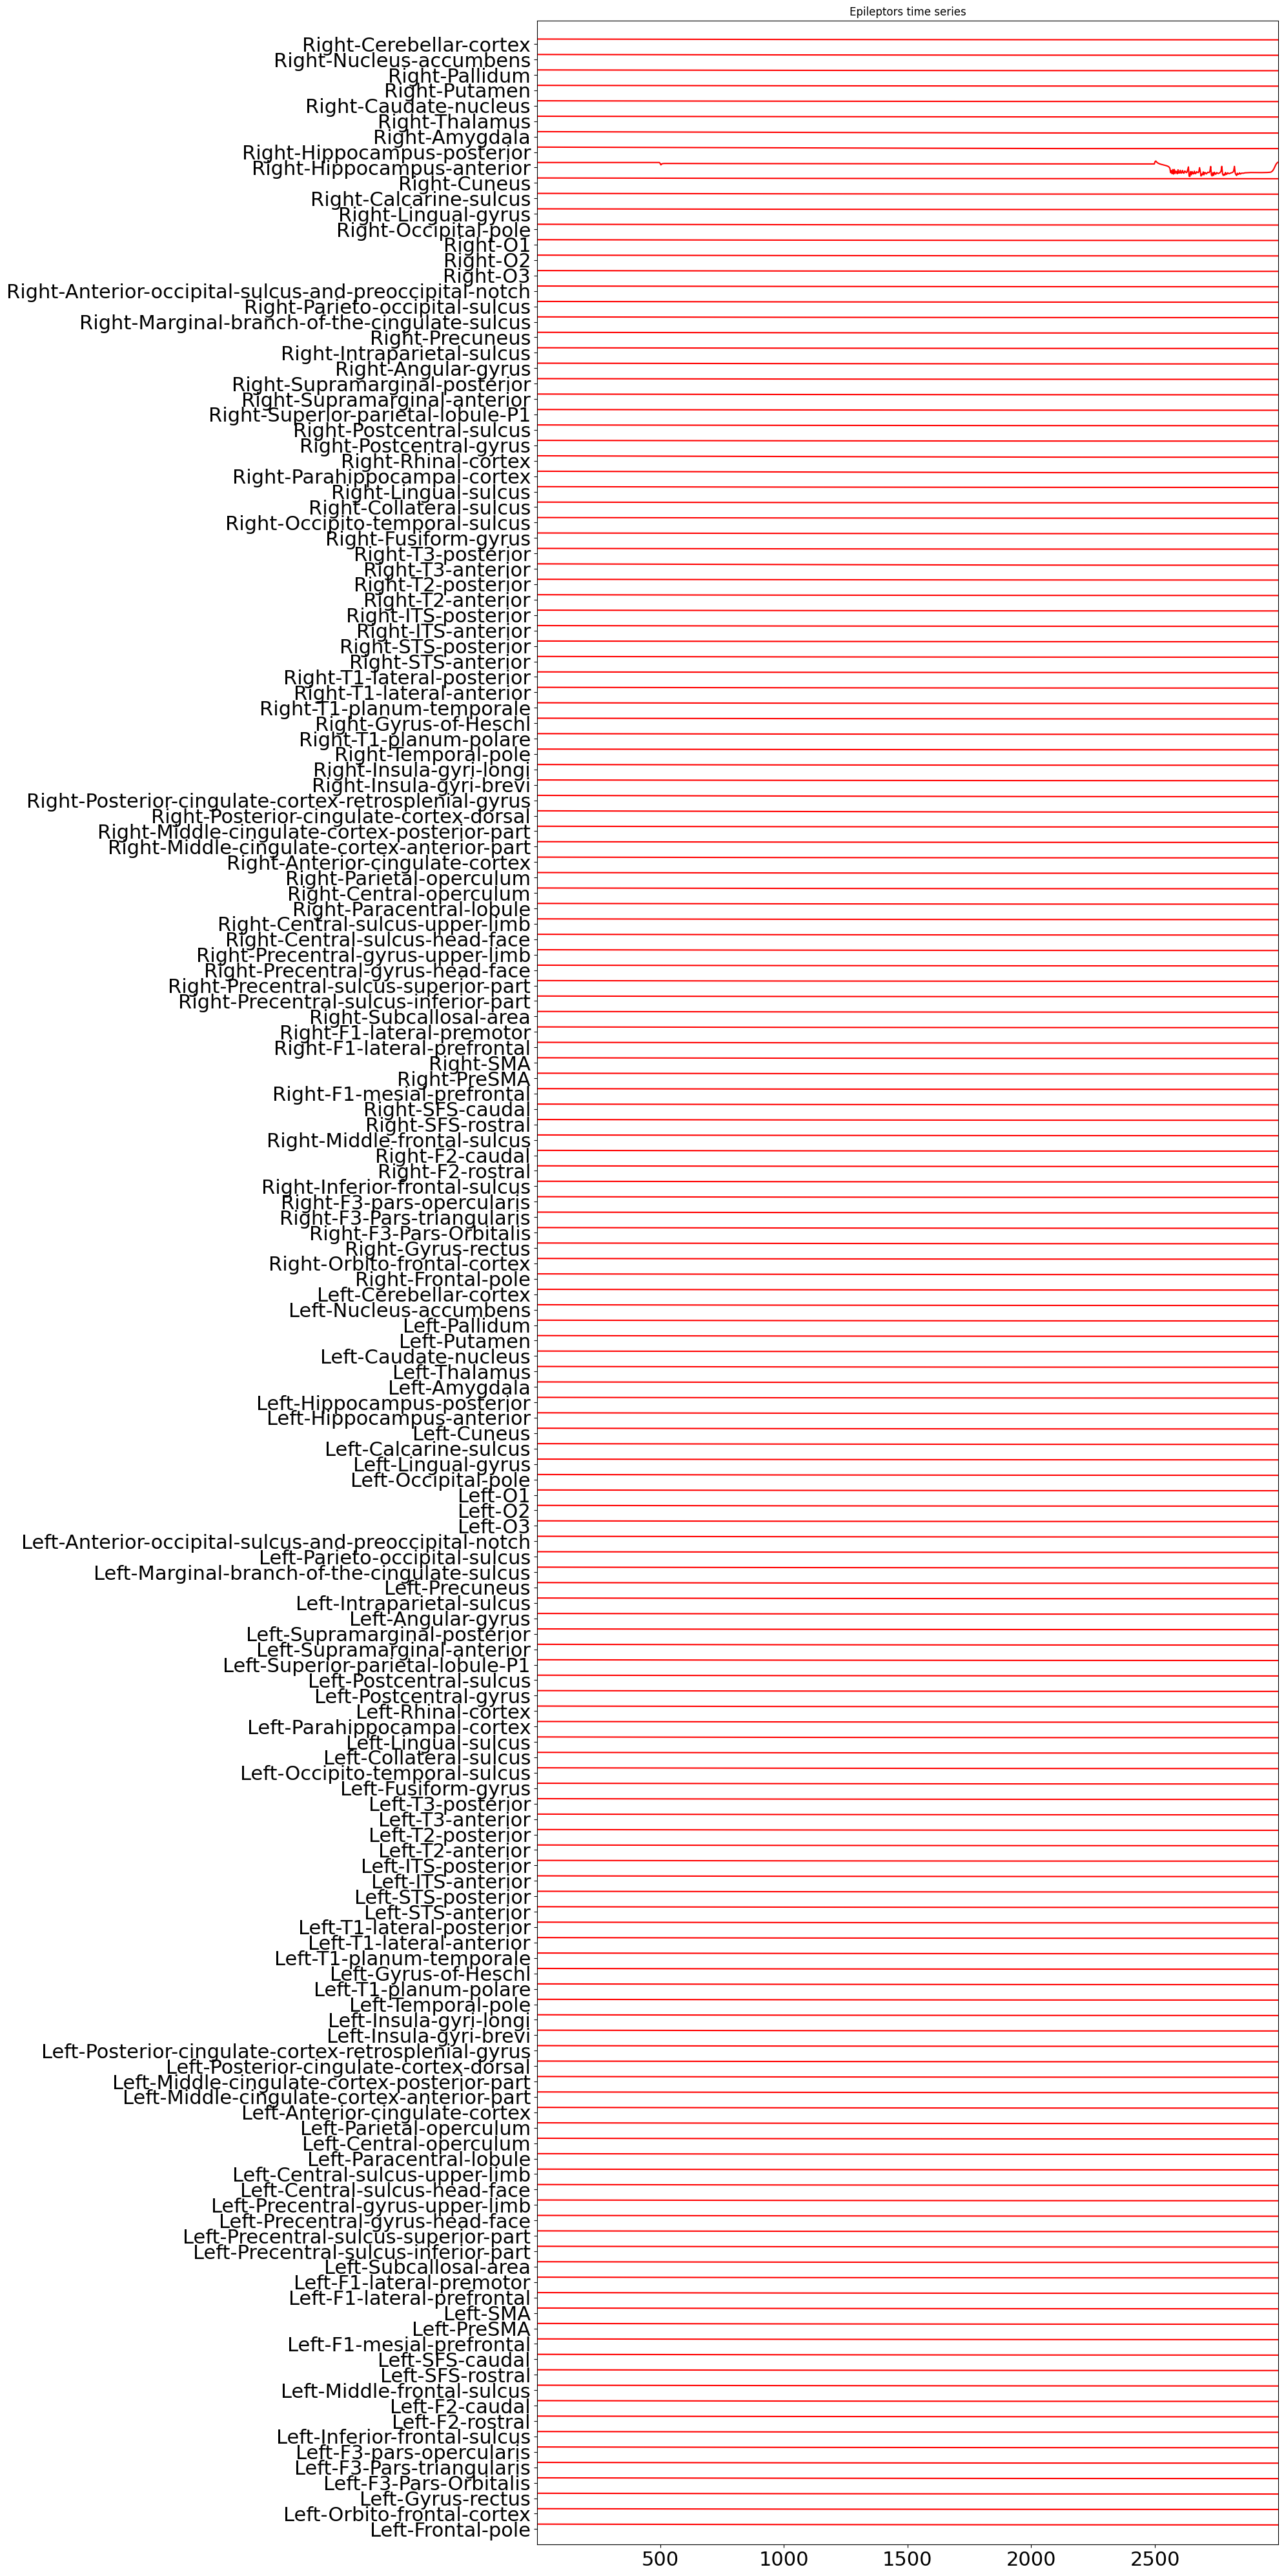

In [429]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

In [430]:
#np.where(roi=='Right-Hippocampus-anterior')[0][0]

## Signal analysis and plottings

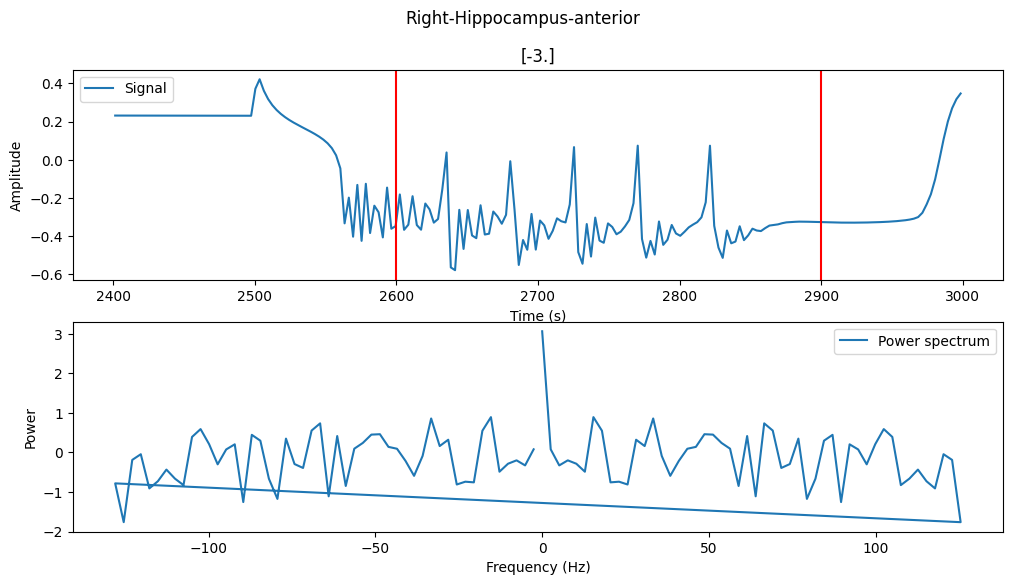

The Power peak is:  3.0633576956702653
The Peak to peak amplitude is:  0.6521771835401668
The absoute power is:  0.1302597538499346
The variance of the amplitude of the signal is:  0.014553270145110018


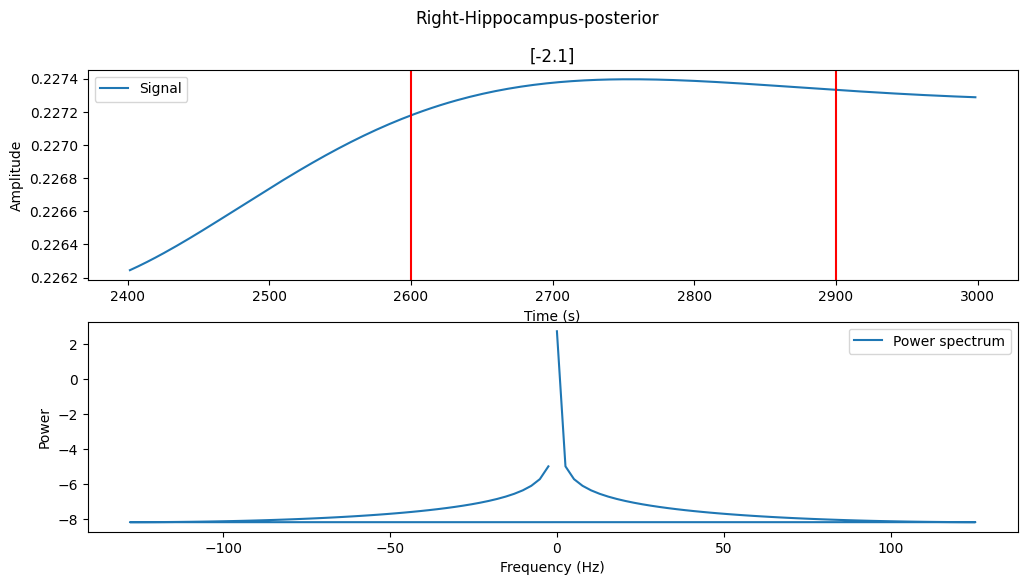

The Power peak is:  2.7133829743591615
The Peak to peak amplitude is:  0.00021894050076204374
The absoute power is:  0.05168719911100153
The variance of the amplitude of the signal is:  2.9000151324623803e-09


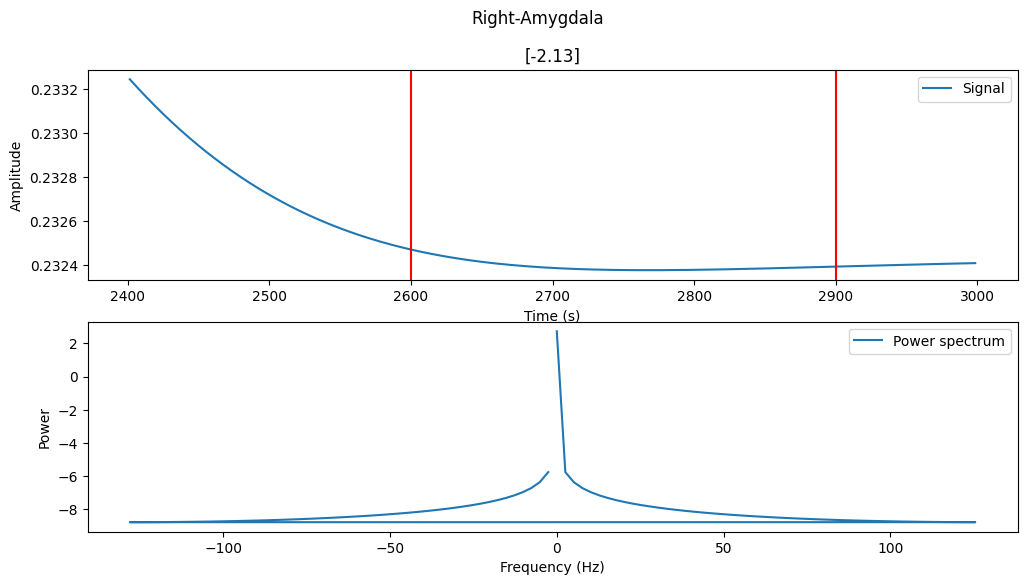

The Power peak is:  2.7324497155015792
The Peak to peak amplitude is:  9.488238941021687e-05
The absoute power is:  0.05400695851610699
The variance of the amplitude of the signal is:  5.614581267960405e-10


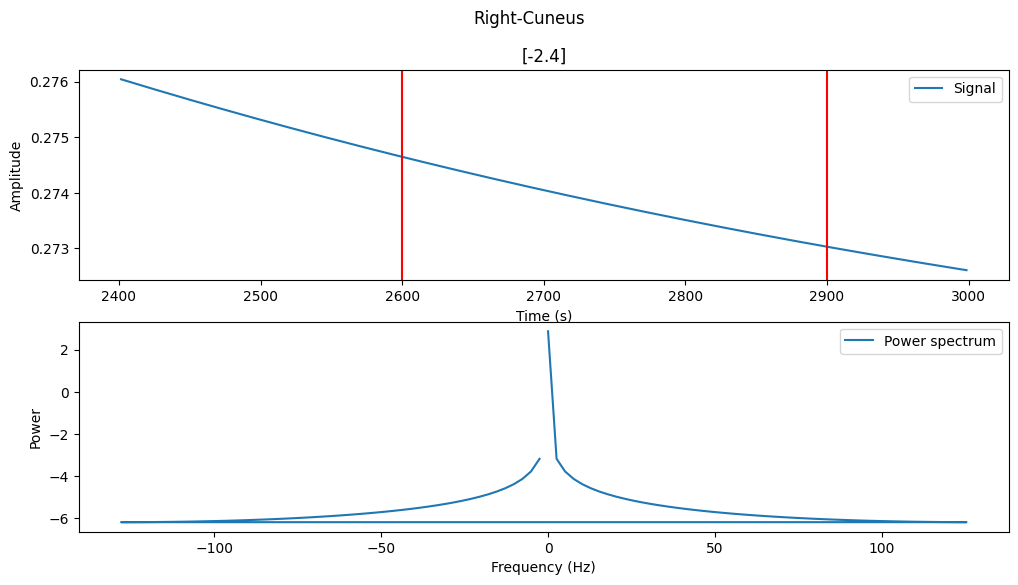

The Power peak is:  2.87487764084731
The Peak to peak amplitude is:  0.0016062069062752204
The absoute power is:  0.07496851535068706
The variance of the amplitude of the signal is:  2.1913793937066734e-07


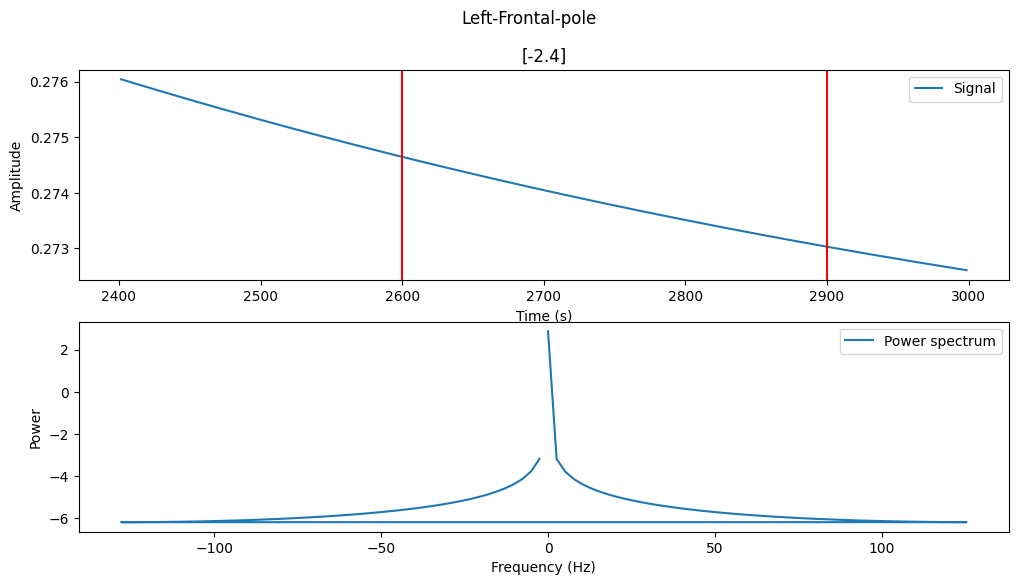

The Power peak is:  2.87487764084731
The Peak to peak amplitude is:  0.0016062069062752204
The absoute power is:  0.07496851535068706
The variance of the amplitude of the signal is:  2.1913793937066734e-07


In [431]:
myroi = ['Right-Hippocampus-anterior', 'Right-Hippocampus-posterior', 'Right-Amygdala', 'Right-Cuneus', 'Left-Frontal-pole']
PpA = []
p2paA = []
abspowerA = []
varianceA = []

for k in myroi:    
    mySig = srcSig_normal[int((stim_length+100)/3):int((stim_length+400)/3), np.where(roi==k)[0][0]]
    power = np.mean(np.abs(mySig)**2)
    power
    # Compute the FFT and the power spectrum
    X = np.fft.fft(mySig) # FFT array
    P = np.abs(X)**2 # Power spectrum array
    f = np.fft.fftfreq(len(mySig), 1/256) # Frequency array

    # Shift the spectrum and the frequencies
    #X = np.fft.fftshift(X) # Shifted FFT array
    #P = np.fft.fftshift(P) # Shifted power spectrum array
    #f = np.fft.fftshift(f) # Shifted frequency array

    P = np.log10(P)

    # Plot the signal and the spectrum
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    plt.plot(tts[int((stim_length-100)/3):int((simulation_length)/3)], srcSig_normal[int((stim_length-100)/3):int((simulation_length)/3), np.where(roi==k)[0][0]], label='Signal')
    plt.suptitle(k)
    plt.title(epileptors.x0[np.where(roi==k)])
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.axvline(x=(stim_length+100), color='r')
    plt.axvline(x=(stim_length+400), color='r')
    plt.legend()
    plt.subplot(212)
    plt.plot(f, P, label='Power spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    #plt.xlim(0, 40) # Zoom in to the relevant frequency range
    plt.legend()
    plt.show()
    
    Pp = max(P)
    print('The Power peak is: ', Pp)
    PpA.append(Pp)
    
    #Peak to peak amplitude
    p2pa = max(mySig) - min(mySig)
    print('The Peak to peak amplitude is: ', p2pa)
    p2paA.append(p2pa)
    
    #Absolute power
    abspower = np.mean(mySig**2)
    print('The absoute power is: ', abspower)
    abspowerA.append(abspower)
    
    #Variance of the amplitude
    variance = np.mean((mySig - np.mean(mySig))**2)
    print('The variance of the amplitude of the signal is: ', variance)
    varianceA.append(variance)

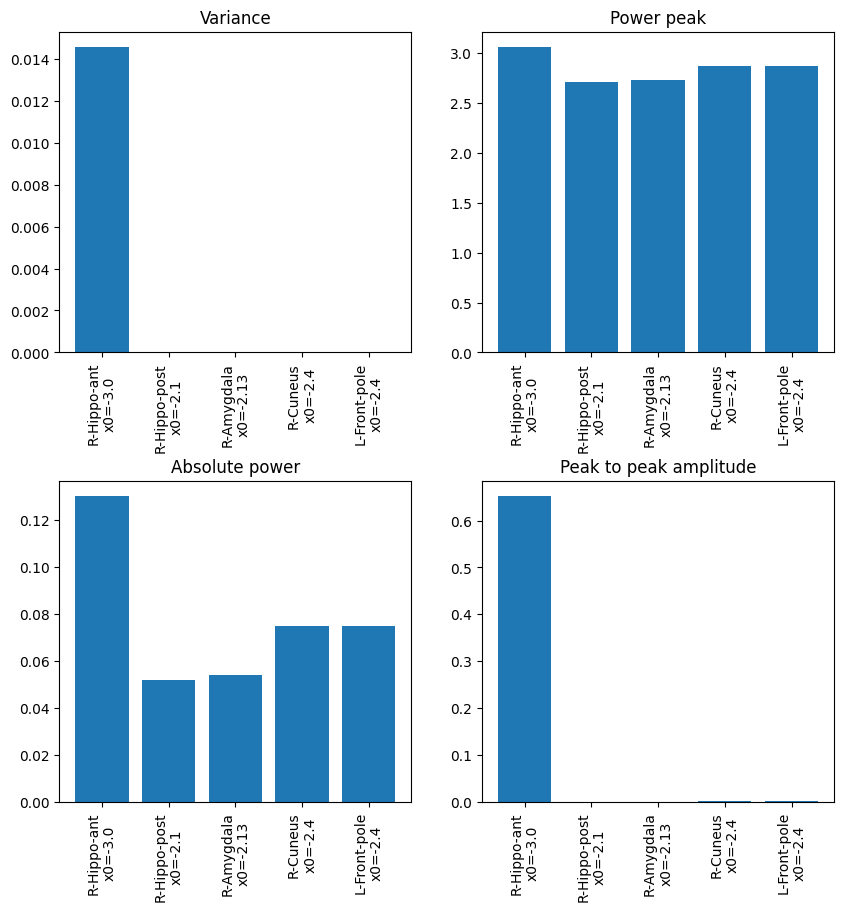

In [432]:
myshortroi = ['R-Hippo-ant', 'R-Hippo-post', 'R-Amygdala', 'R-Cuneus', 'L-Front-pole']
strxo = []
for j in myroi:
    strxo.append(str(round(float(epileptors.x0[np.where(roi==j)][0]),3)))
myx0roi = []  
for jj, kk in enumerate(myshortroi):
    myx0roi.append(kk+"\nx0="+strxo[jj])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,10))

ax[0][0].bar(np.arange(0,len(myroi),1), varianceA)
ax[0][0].tick_params(axis='x', rotation=90)
ax[0][0].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[0][0].set_title("Variance")

ax[1][0].bar(np.arange(0,len(myroi),1), abspowerA)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][0].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[1][0].set_title("Absolute power")

ax[0][1].bar(np.arange(0,len(myroi),1), PpA)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][1].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[0][1].set_title("Power peak")

ax[1][1].bar(np.arange(0,len(myroi),1), p2paA)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][1].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[1][1].set_title("Peak to peak amplitude")

plt.subplots_adjust(hspace=0.4)
plt.show()


## Now let's apply the drug

-2.461000000000062 became -2.708000000000035
-2.708000000000035


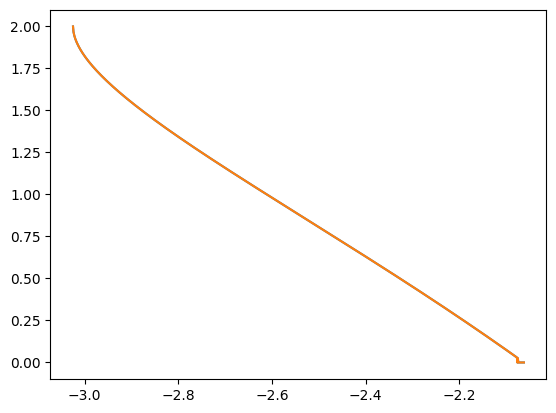

In [64]:
drug = 'valproate'
dose = 15
starting_x0ez = x0ez
#starting_x0pz = x0ez

final_x0ez = mest_function.dose_effect(drug, dose, starting_x0ez)
all_the_deltas, X0s = mest_function.f1_find_the_delta()
#final_x0pz = round(mest_function.dose_effect(drug, dose, starting_x0pz),3)


print(final_x0ez)

Stimuli applied from the SEEG electrode


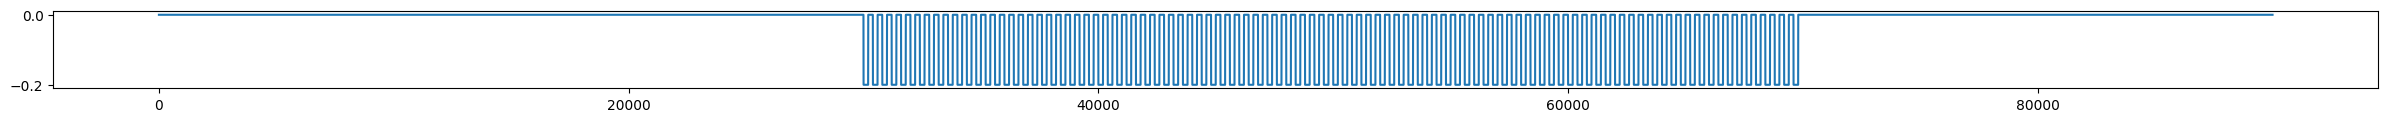

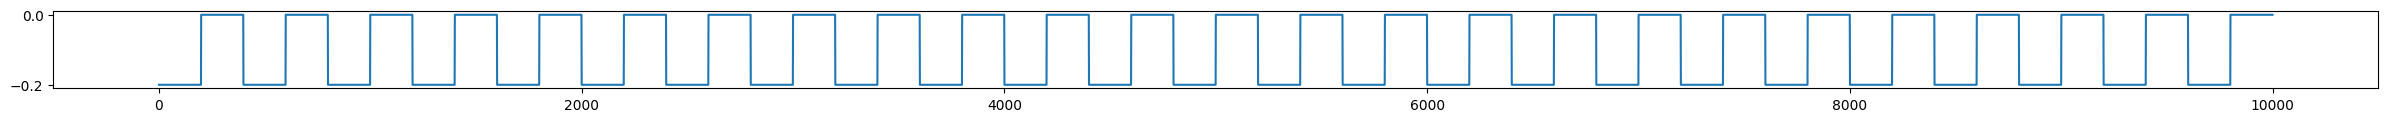

In [57]:
dt = 0.05
onset = 1500 # ms
stim_length = onset + 2000 # stimulation length (including onset) ms
simulation_length = 4500 # ms
freq = 50/1000 # frequency converted to 1/ms
T = 1/freq # pulse repetition period [ms]
tau = 10 # pulse width [ms]
I = 0.2 # intensity [mA]

# Temporal stimulation pattern
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]
pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

print("Stimuli applied from the SEEG electrode")
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts[60000:70000])
plt.show()

In [58]:
# Here we set up the EZ node such that it is close to the critical working point, i.e. the seizure threshold
x0ez= -2.4
x0pz= -2.4
x0num=-2.4

epileptors = models.Epileptor(r=np.array([0.00035]))
epileptors.x0 = x0num*np.ones(nb_regions)
epileptors.x0[idx_EZ] = x0ez
for id in idx_PZ:
    epileptors.x0[id] = x0pz
    x0pz -= 0.01

# Initial conditions
init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

# Spatial stimulation pattern (via weights accross the network nodes)
stim_weight = 3
stim_weights = np.zeros((nb_regions))
stim_weights[idx_EZ] = np.array([stim_weight])
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=con,
                                  weight=stim_weights)
stimulus.configure_space()
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus, 
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 110.5552430152893


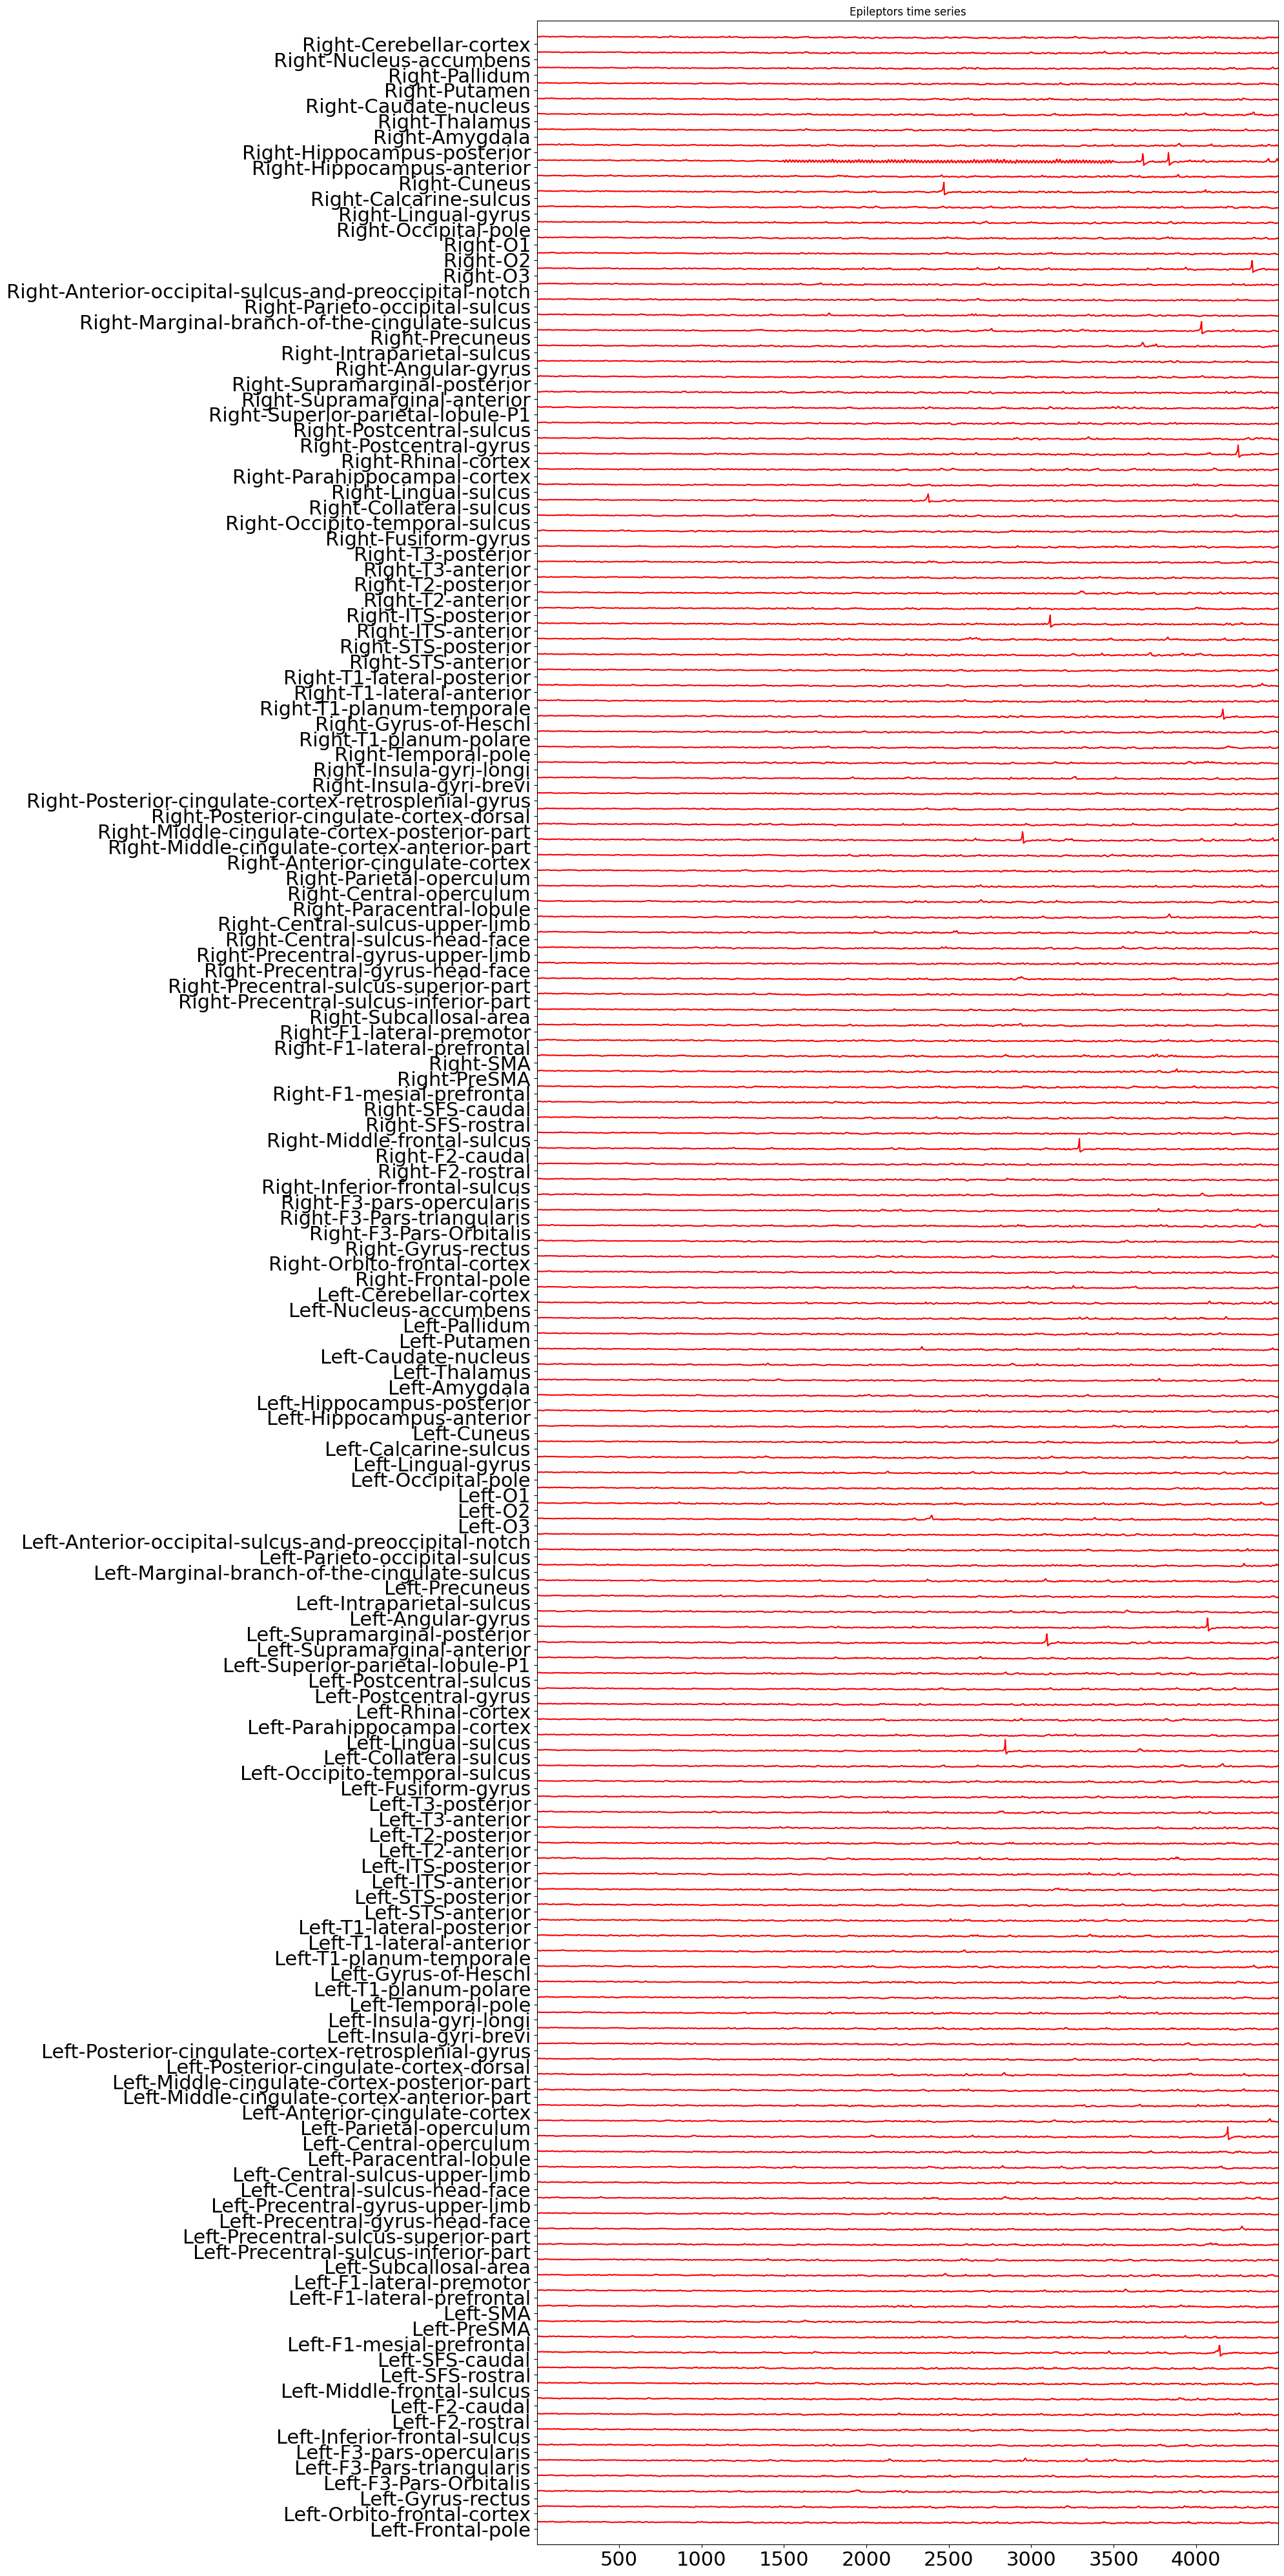

In [59]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

## Hippo anterior

In [ ]:
myroi = ['Right-Hippocampus-anterior', 'Right-Hippocampus-posterior', 'Right-Amygdala', 'Right-Cuneus', 'Left-Frontal-pole']
PpA1 = []
p2paA1 = []
abspowerA1 = []
varianceA1 = []

for k in myroi:    
    mySig = srcSig_normal[int(4300/3):int(4800/3), np.where(roi==k)[0][0]]
    power = np.mean(np.abs(mySig)**2)
    power
    # Compute the FFT and the power spectrum
    X = np.fft.fft(mySig) # FFT array
    P = np.abs(X)**2 # Power spectrum array
    f = np.fft.fftfreq(len(mySig), 1/256) # Frequency array

    # Shift the spectrum and the frequencies
    #X = np.fft.fftshift(X) # Shifted FFT array
    #P = np.fft.fftshift(P) # Shifted power spectrum array
    #f = np.fft.fftshift(f) # Shifted frequency array

    P = np.log10(P)

    # Plot the signal and the spectrum
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    plt.plot(tts[int(3600/3):int(5000/3)], srcSig_normal[int(3600/3):int(5000/3), np.where(roi==k)[0][0]], label='Signal')
    plt.title(k)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.axvline(x=4300, color='r')
    plt.axvline(x=4800, color='r')
    plt.legend()
    plt.subplot(212)
    plt.plot(f, P, label='Power spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    #plt.xlim(0, 40) # Zoom in to the relevant frequency range
    plt.legend()
    plt.show()
    
    Pp = max(P)
    print('The Power peak is: ', Pp)
    PpA1.append(Pp)
    
    #Peak to peak amplitude
    p2pa = max(mySig) - min(mySig)
    print('The Peak to peak amplitude is: ', p2pa)
    p2paA1.append(p2pa)
    
    #Absolute power
    abspower = np.mean(mySig**2)
    print('The absoute power is: ', abspower)
    abspowerA1.append(abspower)
    
    #Variance of the amplitude
    variance = np.mean((mySig - np.mean(mySig))**2)
    print('The variance of the amplitude of the signal is: ', variance)
    varianceA1.append(variance)

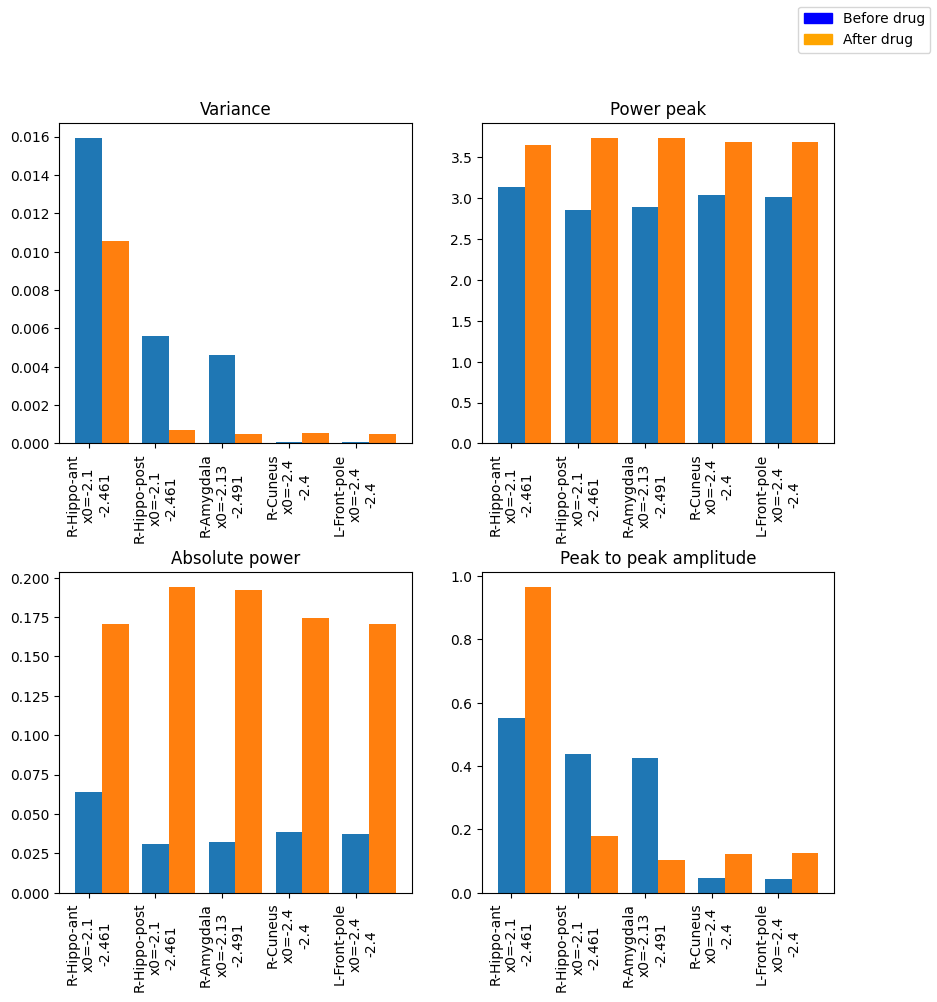

In [32]:
import matplotlib.patches as mpatch

myshortroi = ['R-Hippo-ant', 'R-Hippo-post', 'R-Amygdala', 'R-Cuneus', 'L-Front-pole']

newstrxo = []
for j in myroi:
    newstrxo.append(str(round(float(epileptors.x0[np.where(roi==j)][0]),3)))
myx0roi = []  
for jj, kk in enumerate(myshortroi):
    myx0roi.append(kk+"\nx0="+strxo[jj]+"\n"+newstrxo[jj])

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (10,10))

width = 0.4

ax[0][0].bar(np.arange(0,len(myroi),1), varianceA, width = width)
ax[0][0].bar(np.arange(0,len(myroi),1)+width, varianceA1, width = width)
ax[0][0].tick_params(axis='x', rotation=90)
ax[0][0].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[0][0].set_title("Variance")

ax[1][0].bar(np.arange(0,len(myroi),1), abspowerA, width = width)
ax[1][0].bar(np.arange(0,len(myroi),1)+width, abspowerA1, width = width)
ax[1][0].tick_params(axis='x', rotation=90)
ax[1][0].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[1][0].set_title("Absolute power")

ax[0][1].bar(np.arange(0,len(myroi),1), PpA, width = width)
ax[0][1].bar(np.arange(0,len(myroi),1)+width, PpA1, width = width)
ax[0][1].tick_params(axis='x', rotation=90)
ax[0][1].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[0][1].set_title("Power peak")

ax[1][1].bar(np.arange(0,len(myroi),1), p2paA, width = width)
ax[1][1].bar(np.arange(0,len(myroi),1)+width, p2paA1, width = width)
ax[1][1].tick_params(axis='x', rotation=90)
ax[1][1].set_xticks(np.arange(0,len(myroi),1), labels = myx0roi)
ax[1][1].set_title("Peak to peak amplitude")

plt.subplots_adjust(hspace=0.4)
orange_patch = mpatch.Patch(color = 'orange', label = 'After drug')
blue_patch = mpatch.Patch(color = 'blue', label = 'Before drug')
fig.legend(handles = [blue_patch, orange_patch])

plt.show()


## Now let's what new stimulus is needed for making it seize again :)

Stimuli applied from the SEEG electrode =  0.57


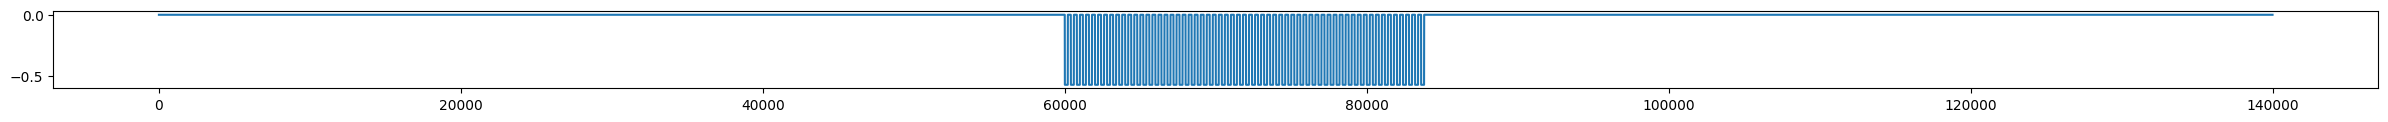

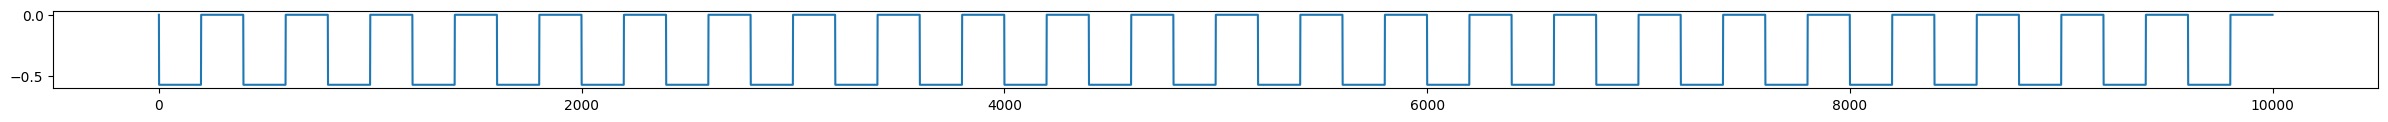

In [99]:
dt = 0.05
onset = 3000 # ms
stim_length = onset + 1200 # stimulation length (including onset) ms
simulation_length = 7000 # ms
freq = 50/1000 # frequency converted to 1/ms
T = 1/freq # pulse repetition period [ms]
tau = 10 # pulse width [ms]
I = 0.57 #round(all_the_deltas[np.where(X0s == round(x0ez, 3))[0][0]], 2) # intensity [mA]

# Temporal stimulation pattern
class vector1D(equations.DiscreteEquation):
    equation = equations.Final(default="emp")
eqn_t = vector1D()
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset}
pulse1, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse1_ts = [p[1] for p in pulse1]
parameters = {'T': T, 'tau': tau, 'amp': I, 'onset': onset + tau}
pulse2, _ = equations.PulseTrain(parameters=parameters).get_series_data(max_range=stim_length, step=dt)
pulse2_ts = [p[1] for p in pulse2]
pulse_ts = -np.asarray(pulse1_ts) #- np.asarray(pulse2_ts)
stimulus_ts = np.hstack((pulse_ts[:-1], np.zeros(int(np.ceil((simulation_length - stim_length) / dt)))))
eqn_t.parameters['emp'] = np.copy(stimulus_ts)

print("Stimuli applied from the SEEG electrode = ", I)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts)
plt.figure(figsize=(30, 1))
plt.plot(stimulus_ts[60000:70000])
plt.show()

In [100]:
# Initial conditions
init_cond = np.array([-1.98742113e+00 , -1.87492138e+01, 4.0529597e+00, -1.05214059e+00, -4.95543740e-20, -1.98742113e-01])
print(init_cond)
init_cond_reshaped = np.repeat(init_cond, nb_regions).reshape((1, len(init_cond), nb_regions, 1))

# Spatial stimulation pattern (via weights accross the network nodes)
stim_weight = 3
stim_weights = np.zeros((nb_regions))
stim_weights[idx_EZ] = np.array([stim_weight])
stimulus = patterns.StimuliRegion(temporal=eqn_t,
                                  connectivity=con,
                                  weight=stim_weights)
stimulus.configure_space()
stimulus.configure_time(np.arange(0., np.size(stimulus_ts), 1))

# Simulator
sim = simulator.Simulator(model=epileptors,
                          stimulus=stimulus, 
                          initial_conditions=init_cond_reshaped,
                          connectivity=con,
                          coupling=coupl,
                          integrator=heunint,
                          monitors=mons)

sim.configure()

# Run
simulation_length = 7000
print("Starting simulation...")
tic = tm.time()
ttavg = sim.run(simulation_length=simulation_length)
print("Finished simulation.")
print('execute for ' + str(tm.time()-tic))

[-1.98742113e+00 -1.87492138e+01  4.05295970e+00 -1.05214059e+00
 -4.95543740e-20 -1.98742113e-01]
Starting simulation...
Finished simulation.
execute for 173.3327386379242


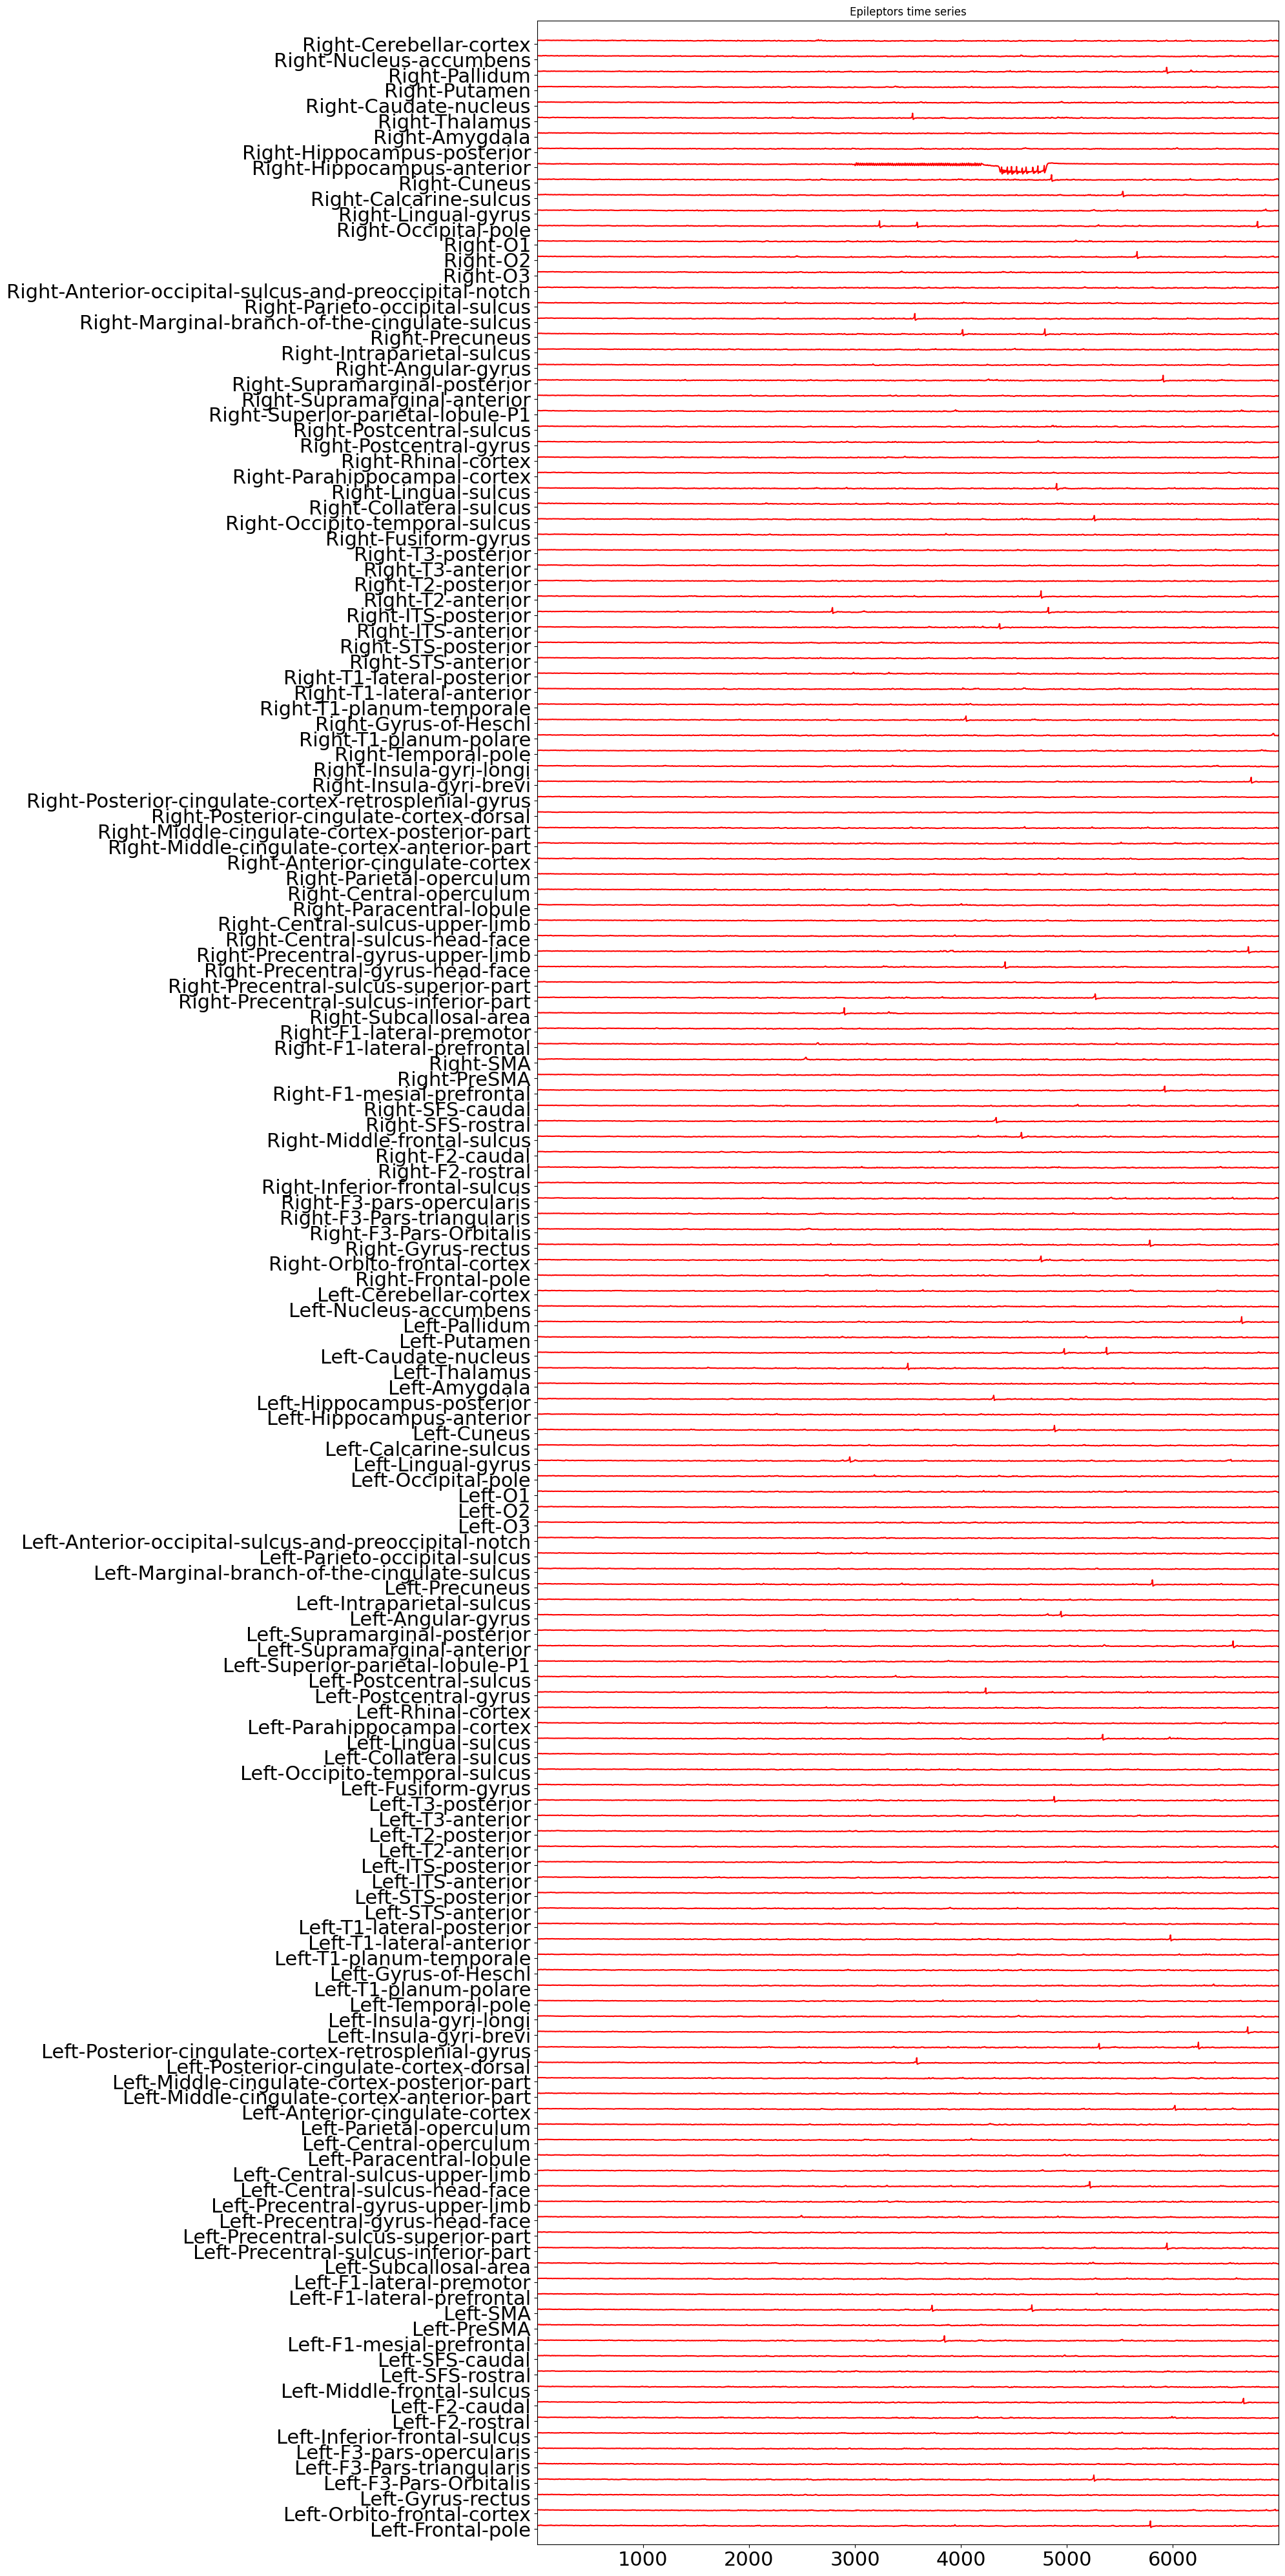

In [101]:
tts = ttavg[0][0]
tavg = ttavg[0][1]
srcSig = tavg[:,0,:,0]
start_idx = 0
end_idx = tavg.shape[0]

srcSig_normal=srcSig/np.ptp(srcSig)
#Plot raw time series
figure= plt.figure(figsize=(20,40))
plt.plot(tts[start_idx:end_idx], srcSig_normal[start_idx:end_idx] + np.r_[:162], 'r')
plt.title("Epileptors time series")
roi = con.region_labels
plt.yticks(np.arange(len(roi)),roi, fontsize=22)

# These should be set manually, since they depend on the model parameters
plt.xticks(fontsize=22)
plt.ylim([-1,len(roi)+0.5])
plt.xlim([tts[start_idx],tts[end_idx-1]])
plt.tight_layout()
plt.show()

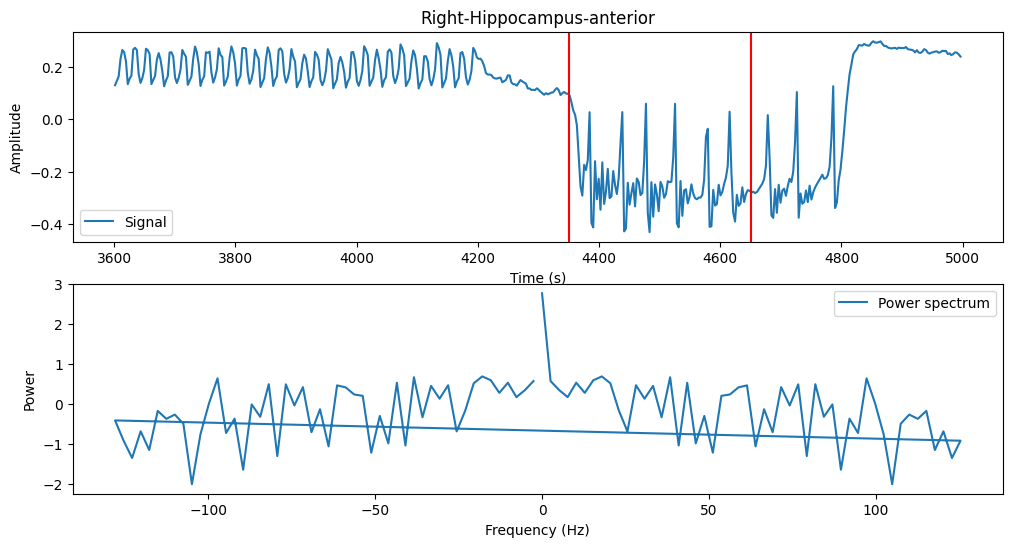

The Power peak is:  2.774484629002403
The Peak to peak amplitude is:  0.5218225269771768
The absoute power is:  0.07396894436066236
The variance of the amplitude of the signal is:  0.014473374450515464


In [102]:
myroi = ['Right-Hippocampus-anterior']
PpA1 = []
p2paA1 = []
abspowerA1 = []
varianceA1 = []

for k in myroi:    
    mySig = srcSig_normal[int(4350/3):int(4650/3), np.where(roi==k)[0][0]]
    power = np.mean(np.abs(mySig)**2)
    power
    # Compute the FFT and the power spectrum
    X = np.fft.fft(mySig) # FFT array
    P = np.abs(X)**2 # Power spectrum array
    f = np.fft.fftfreq(len(mySig), 1/256) # Frequency array

    # Shift the spectrum and the frequencies
    #X = np.fft.fftshift(X) # Shifted FFT array
    #P = np.fft.fftshift(P) # Shifted power spectrum array
    #f = np.fft.fftshift(f) # Shifted frequency array

    P = np.log10(P)

    # Plot the signal and the spectrum
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    plt.plot(tts[int(3600/3):int(5000/3)], srcSig_normal[int(3600/3):int(5000/3), np.where(roi==k)[0][0]], label='Signal')
    plt.title(k)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.axvline(x=4350, color='r')
    plt.axvline(x=4650, color='r')
    plt.legend()
    plt.subplot(212)
    plt.plot(f, P, label='Power spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    #plt.xlim(0, 40) # Zoom in to the relevant frequency range
    plt.legend()
    plt.show()
    
    Pp = max(P)
    print('The Power peak is: ', Pp)
    PpA1.append(Pp)
    
    #Peak to peak amplitude
    p2pa = max(mySig) - min(mySig)
    print('The Peak to peak amplitude is: ', p2pa)
    p2paA1.append(p2pa)
    
    #Absolute power
    abspower = np.mean(mySig**2)
    print('The absoute power is: ', abspower)
    abspowerA1.append(abspower)
    
    #Variance of the amplitude
    variance = np.mean((mySig - np.mean(mySig))**2)
    print('The variance of the amplitude of the signal is: ', variance)
    varianceA1.append(variance)